In [ ]:
#إستدعاء المكتبيات
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install patool
!pip install pyunpack
from pyunpack import Archive

In [ ]:
Archive("/data/binaryAllNaturalPlusNormalVsAttacks.7z").extractall(".")

In [ ]:
df1=pd.read_csv("/data/data1.csv")
df2=pd.read_csv("/data/data2.csv")
df3=pd.read_csv("/data/data3.csv")
df4=pd.read_csv("/data/data4.csv")
df5=pd.read_csv("/data/data5.csv")
df6=pd.read_csv("/data/data6.csv")
df7=pd.read_csv("/data/data7.csv")
df8=pd.read_csv("/data/data8.csv")
df9=pd.read_csv("/data/data9.csv")
df10=pd.read_csv("/data/data10.csv")
df11=pd.read_csv("/data/data11.csv")
df12=pd.read_csv("/data/data12.csv")
df13=pd.read_csv("/data/data13.csv")
df14=pd.read_csv("/data/data14.csv")
df15=pd.read_csv("/data/data15.csv")

In [ ]:
#دمج مجموعات البيانات
df = pd.concat([df1, df2,df3,df4, df5,df6,df7, df8,df9,df10, df11,df12,df13, df14,df15])

In [ ]:
#تحويل الكلمات إلى أرقام للعمود marker
#target equal 0 is natural
#target equal 1 is Attack
df.loc[df["marker"] == "Natural", "marker"] = 0
df.loc[df["marker"] =="Attack", "marker"] = 1

In [ ]:
# إحصاء القيم
df["marker"].value_counts()

1    55663
0    22714
Name: marker, dtype: int64

In [ ]:
#سيعطي هذا مجموعة من الأماكن حيث توجد قيم NA.
 
df[df==np.inf]=np.nan
df.fillna(df.mean(), inplace=True)
#ذا كانت بياناتك تحتوي على Nan ، فجرّب ما يلي:
np.isnan(df.values.any())

False

In [ ]:
X= df.drop("marker", axis = 1)
X=X.astype(float)
 
from sklearn.preprocessing import Normalizer
transformer= Normalizer().fit(X) 
transformer
S=transformer.transform(X)

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
 
x = pd.DataFrame(ss.fit_transform(S))
 
y = df["marker"]
 
x.head()

0         1         2    ...       125      126       127
0  0.874304  0.099036 -0.474731  ... -0.007144 -0.00943 -0.008728
1  0.889684  0.036331 -0.434350  ... -0.007144 -0.00943 -0.008728
2  0.890043  0.037227 -0.433884  ... -0.007144 -0.00943 -0.008728
3  0.891902  0.036003 -0.429791  ... -0.007144 -0.00943 -0.008728
4  0.893597  0.033239 -0.423901  ... -0.007144 -0.00943 -0.008728

[5 rows x 128 columns]

In [ ]:
# categorical target y to array 
from keras.utils.np_utils import to_categorical
 
y_cat = to_categorical(y,2)
y_cat[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
#divide datasets into to part training and test
from sklearn.model_selection import train_test_split
 
x_train, x_test, y_train, y_test = train_test_split(x.values, y_cat,test_size=0.1,random_state=0)

In [ ]:
#reshape x_train,x_test,y_train and y_test
X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
Y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
Y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

In [ ]:
print(X_test.shape)
 
print(X_train.shape)

In [ ]:
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
i=x_train.shape[1]
rnn_model = keras.Sequential([
    layers.SimpleRNN(128, activation="tanh", input_shape=[1,i] ,return_sequences=True,kernel_initializer="he_uniform"),
    
    layers.SimpleRNN(256,activation="tanh",return_sequences=True,kernel_initializer="he_uniform"),
 
    layers.SimpleRNN(128,activation="tanh",return_sequences=False,kernel_initializer="he_uniform"),
    layers.Dropout(0.01),
    layers.Dense(2, activation="sigmoid",kernel_initializer="he_uniform")
  ])
 
optimizer = tf.keras.optimizers.Adam(0.001,decay=0.000005)
rnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=optimizer,
                metrics=['accuracy'])
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 128)            32896     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1, 256)            98560     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               49280     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 180,994
Trainable params: 180,994
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!pip install h5py

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_RNN_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
rp = ReduceLROnPlateau(monitor='val_accuracy',patience = 5,verbose=1,factor=0.5,min_lr=0.001)

In [ ]:
start_time = time.time()
fit1 = rnn_model.fit(X_train, y_train, epochs=250, batch_size=500,callbacks=[es, mc,rp],validation_split=0.1)
duration = time.time() - start_time
print("time of training (s)", duration)

Epoch 1/250
126/127 [============================>.] - ETA: 0s - loss: 0.5941 - accuracy: 0.7061
Epoch 00001: val_accuracy improved from -inf to 0.71406, saving model to best_RNN_model.h5
127/127 [==============================] - 1s 9ms/step - loss: 0.5942 - accuracy: 0.7060 - val_loss: 0.5807 - val_accuracy: 0.7141
Epoch 2/250
122/127 [===========================>..] - ETA: 0s - loss: 0.5747 - accuracy: 0.7170
Epoch 00002: val_accuracy improved from 0.71406 to 0.71747, saving model to best_RNN_model.h5
127/127 [==============================] - 1s 6ms/step - loss: 0.5742 - accuracy: 0.7173 - val_loss: 0.5682 - val_accuracy: 0.7175
Epoch 3/250
124/127 [============================>.] - ETA: 0s - loss: 0.5617 - accuracy: 0.7202
Epoch 00003: val_accuracy did not improve from 0.71747
127/127 [==============================] - 1s 6ms/step - loss: 0.5616 - accuracy: 0.7202 - val_loss: 0.5606 - val_accuracy: 0.7136
Epoch 4/250
121/127 [===========================>..] - ETA: 0s - loss: 0.552

In [ ]:
def viz(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()
 
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

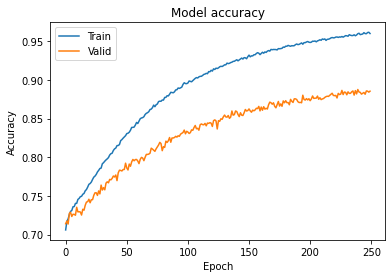

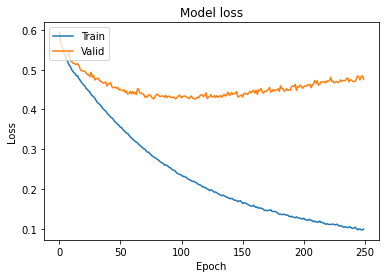

In [ ]:
viz(fit1)
#fit1.history

In [ ]:
# load a saved model
from keras.models import load_model
saved_model = load_model('best_RNN_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.966, Test: 0.886


In [ ]:
 
import time
 
Xnew=[['70.39932429', '127673.0908', '-49.57230843', '127648.0176', '-169.5783186', '127723.2374', '65.68961121', '605.91099', '-57.00357104', '626.78553', '-173.5890232', '602.4319', '70.4222426', '127673.0908', '0', '0', '0', '0', '65.00779144', '611.5874', '118.5678861', '13.18392', '-100.8692198', '13.91636', '59.999', '0.01', '6.391383458', '0.076290455', '0', '60.65826798', '124631.8125', '-59.29595943', '124484.3594', '-179.3380777', '124715.0703', '-119.5504813', '612.7967529', '117.7267525', '632.5321045', '0.859680212', '610.1417236', '60.6802407', '124611.9844', '0', '0', '0', '0', '-120.3414991', '618.3013916', '-64.05304275', '12.7658844', '69.39789118', '12.8288269', '59.99900055', '0.02', '6.130100104', '3.135101005', '0', '60.66477135', '124187.9063', '-59.31259095', '124162.833', '-179.3014124', '124212.9796', '-119.7539088', '610.12252', '117.6855311', '628.25041', '0.658901464', '606.82654', '60.68768966', '124187.9063', '0', '0', '0', '0', '-120.4872947', '614.88338', '-64.81298579', '12.08526', '70.38786513', '11.90215', '59.999', '0.02', '6.111439531', '3.140520023', '0', '70.45089049', '127723.2374', '-49.53793097', '127096.4056', '-169.532482', '127773.3839', '65.64377459', '604.44611', '-56.87179074', '621.84156', '-173.8697725', '599.86836', '70.46234965', '127522.6512', '0', '0', '0', '0', '64.95049566', '608.47453', '119.3012721', '12.26837', '-102.060972', '11.71904', '59.999', '0.01', '6.341831592', '0.077897157', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']]#normal    
 
Q=[['8.508423258', '130832.3229', '-111.4632095', '130782.1763', '128.5258926', '130907.5427', '3.729955246', '500.80585', '-116.6026409', '500.62274', '123.632833', '501.35518', '8.519882414', '130832.3229', '0', '0', '0', '0', '3.586715798', '500.98896', '0', '0', '0', '0', '60', '0', '7.438322484', '0.077833008', '0', '0.920105028', '128836.9766', '-119.0066616', '128699.4609', '120.9347557', '128913.4688', '176.7782594', '505.7258606', '56.64825709', '507.2078857', '-63.31146179', '506.9961548', '0.94757082', '128814.1563', '0', '0', '0', '0', '176.7068566', '506.6356812', '0', '0', '0', '0', '60', '0', '7.257351968', '-3.071651355', '0', '0.928191628', '128375.1424', '-119.0319819', '128350.0691', '120.9743089', '128400.2157', '176.7173728', '502.63695', '56.61968931', '503.36939', '-63.3290251', '503.00317', '0.95110994', '128375.1424', '0', '0', '0', '0', '176.6715361', '503.00317', '0', '0', '0', '0', '60', '0', '7.268424496', '-3.0691986', '0', '8.559989459', '130857.3961', '-111.428832', '130230.5644', '128.5831884', '130932.6159', '3.707036934', '497.50987', '-116.3619986', '498.24231', '123.741695', '496.59432', '8.571448615', '130681.8832', '0', '0', '0', '0', '3.689848201', '497.50987', '0', '0', '0', '0', '60', '0', '7.489104114', '0.086553421', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']] #normal
 
 
N=[['70.97801166', '130957.6892', '-48.99362106', '130932.6159', '-169.0053608', '131032.909', '66.42872677', '482.31174', '-53.82938485', '483.22729', '-173.646319', '483.77662', '70.99520039', '130982.7625', '0', '0', '0', '0', '66.31986479', '483.04418', '0', '0', '0', '0', '59.999', '0', '7.742501568', '0.074426263', '0', '63.67401507', '129107.1016', '-56.26922599', '128963.9531', '-176.3168392', '129194.8594', '-120.8908103', '488.6340942', '119.1714468', '489.3894043', '-0.826721188', '489.4866943', '63.70147926', '129088.1484', '0', '0', '0', '0', '-120.8468648', '489.1662598', '0', '0', '0', '0', '60', '0', '7.521482155', '-3.061590456', '0', '63.67279977', '128650.9484', '-56.28737379', '128625.8751', '-176.2819248', '128676.0216', '-120.8826356', '485.79083', '119.1981397', '485.42461', '-0.916732472', '485.42461', '63.70144766', '128650.9484', '0', '0', '0', '0', '-120.8711765', '485.42461', '0', '0', '0', '0', '59.999', '0', '7.510130448', '-3.061004926', '0', '71.03530744', '131007.8358', '-48.97070275', '130381.004', '-168.9423355', '131083.0556', '66.42872677', '480.11442', '-53.53717638', '480.11442', '-173.5890232', '479.38198', '71.0467666', '130832.3229', '0', '0', '0', '0', '66.44018592', '479.93131', '0', '0', '0', '0', '60', '0', '7.746914069', '0.08213434', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']] #normal
 
A=[['174.2765725', '98337.36494', '59.20372897', '128550.6553', '-72.71407378', '127347.1383', '100.4796085', '1111.29459', '-4.566473627', '241.33898', '-85.22174245', '621.84156', '173.5546457', '117618.7096', '-9.786119141', '17325.62957', '-13.22959549', '1980.78833', '118.854365', '599.68525', '82.17933656', '420.23745', '78.74731936', '154.36173', '60.016', '-0.04', '1.907633306', '1.477346313', '0', '173.1802387', '47452.82422', '50.77606342', '120554.2734', '-77.66510434', '132296.1563', '-80.08758802', '1147.247314', '170.1754746', '297.0142212', '89.53582968', '636.0683594', '167.4398882', '99778.42969', '-10.8901979', '31715.72461', '-27.77069198', '21617.71094', '-63.9047252', '642.6830444', '-97.7590974', '408.9145508', '-101.4559988', '150.7930756', '60.01599884', '-0.050000001', '0.903115513', '-1.682575032', '0', '173.1822232', '47288.18722', '50.75260149', '120226.3297', '-77.62432208', '131760.0339', '85.92075096', '1062.40422', '-112.9070631', '589.06487', '123.4151091', '150.88264', '167.4526452', '99440.58882', '-10.94922346', '31567.24693', '-27.58791784', '21588.08547', '54.61433703', '466.74739', '103.9746511', '479.01576', '110.2084319', '228.33817', '60.016', '-0.04', '0.793198105', '1.484402105', '0', '169.0225496', '41797.14109', '63.34048425', '121254.3337', '-75.34967964', '121881.1655', '122.4983766', '1748.15117', '72.4218653', '600.23458', '-38.82934978', '177.06737', '173.2395189', '93849.24961', '-3.907572163', '37534.68519', '-2.056918485', '14743.08276', '142.8441079', '707.17082', '112.8039307', '436.16802', '107.7561725', '677.507', '60.014', '-0.04', '0.341509407', '1.111764282', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']]#'Attack'
transformer= Normalizer() 
Z=transformer.transform(Q)
V = ss.transform(Z)
 
V= np.reshape(V, (V.shape[0], 1, V.shape[1]))
start_time = time.time()
 
# make a prediction
ynew = saved_model.predict_classes(V)
# show the inputs and predicted outputs
#for i in range(len(Xnew)):
    #print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))
 
duration = time.time() - start_time
print("time of test (s)", duration)
 
print(ynew)

time of test (s) 0.0375666618347168
[0]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:1829: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  X = check_array(X, accept_sparse='csr')
